In [1]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0
Num GPUs Available:  1


In [2]:
import pandas as pd

df = pd.read_csv('./data.csv')
df.head()

,train,img_path,make,model,x1,y1,x2,y2,maximum_speed,displacement,door_number,seat_number,type,type_name,make_name
0,False,image\78\1\2014\3ac218c0c6c378.jpg,78,1,190,168,724,562,235,1.8,5,5,4,hatchback,Audi
1,False,image\78\1\2010\588feea1fcc809.jpg,78,1,190,168,724,562,235,1.8,5,5,4,hatchback,Audi
2,False,image\78\1\2010\071c428717ceca.jpg,78,1,190,168,724,562,235,1.8,5,5,4,hatchback,Audi
3,False,image\78\1\2010\4c119af3fdb787.jpg,78,1,190,168,724,562,235,1.8,5,5,4,hatchback,Audi
4,False,image\78\1\2014\1453dbb876c191.jpg,78,1,190,168,724,562,235,1.8,5,5,4,hatchback,Audi


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30955 entries, 0 to 30954
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   train          30955 non-null  bool   
 1   img_path       30955 non-null  object 
 2   make           30955 non-null  int64  
 3   model          30955 non-null  int64  
 4   x1             30955 non-null  int64  
 5   y1             30955 non-null  int64  
 6   x2             30955 non-null  int64  
 7   y2             30955 non-null  int64  
 8   maximum_speed  30955 non-null  int64  
 9   displacement   30955 non-null  float64
 10  door_number    30955 non-null  int64  
 11  seat_number    30955 non-null  int64  
 12  type           30955 non-null  int64  
 13  type_name      30955 non-null  object 
 14  make_name      30955 non-null  object 
dtypes: bool(1), float64(1), int64(10), object(3)
memory usage: 3.3+ MB


In [4]:
IMG_SIZE = 224
batch_size = 64
image_dir = './image/'

### Data Split

In [5]:
# resize images
size = (IMG_SIZE, IMG_SIZE)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=image_dir,
    validation_split=0.2,
    shuffle=True,
    subset='training',
    seed=42,
    image_size=size,
    batch_size=batch_size
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=image_dir,
    validation_split=0.2,
    shuffle=True,
    subset='validation',
    seed=42,
    image_size=size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print(class_names)

Found 136726 files belonging to 163 classes.
Using 109381 files for training.
Found 136726 files belonging to 163 classes.
Using 27345 files for validation.
['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7',

In [6]:
NUM_CLASSES = len(class_names)
print(NUM_CLASSES)

163


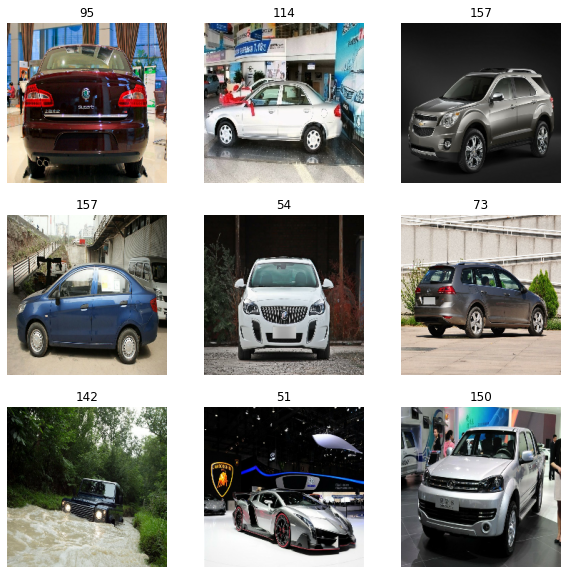

In [7]:
# Visualise some images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


### Data Augmentation

In [9]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

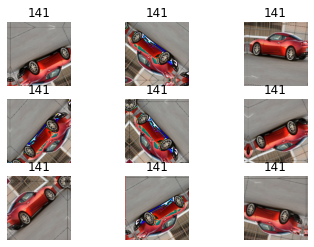

In [10]:
for image_batch, labels_batch in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image_batch[0], axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[0]])
        plt.axis("off")

In [11]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_ds = validation_ds.map(input_preprocess)

In [12]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

from pathlib import Path

def build_model(num_classes, weights_path):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights=weights_path)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.2, name="top_dropout")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [15]:
weights_path = str(Path("./ckpt", "noisy_student_efficientnet-b0", "efficientnetb0_notop.h5"))
model = build_model(NUM_CLASSES, weights_path)
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           img_augmentation[1][0]           
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
_______________________________________________________________________________________

In [16]:
epochs = 1  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, verbose=1)

  61/1710 [>.............................] - ETA: 53:44 - loss: 6.9454 - accuracy: 0.0394

KeyboardInterrupt: 

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)